# Insurance AI Assistant - Powered By RAG

## Problem Statement
Build a RAG system to help Users answer queries on Policy Documents

## System Design - LLM

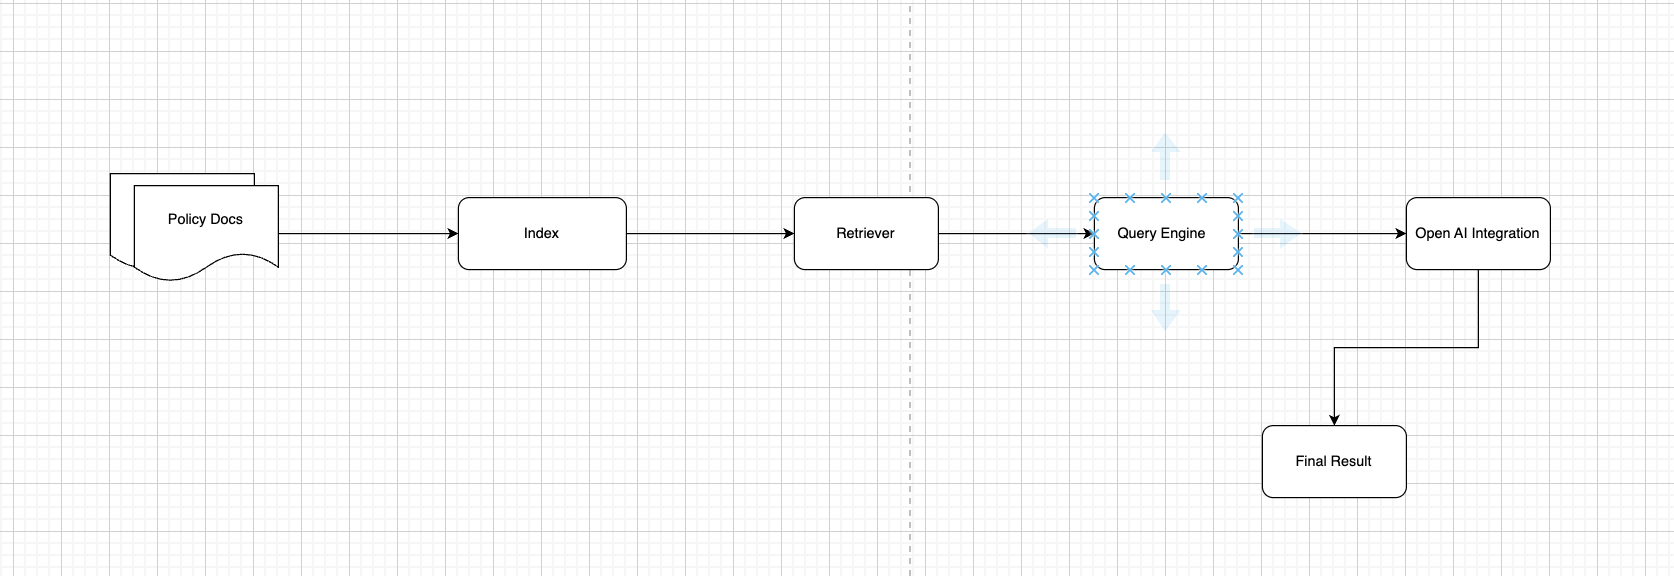

In [22]:
# Install All the Required Libraries
!pip install llama-index-llms-openai
!pip install llama-index
!pip install openai
!pip install pypdf
!pip install docx2txt
!pip install llama-index-postprocessor-cohere-rerank
!pip install diskcache



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00


In [5]:
# Import Required Libraries
import os
import openai
import pandas as pd
from llama_index.llms.openai import OpenAI

## API Key Initialization

In [8]:
# Initialize API Key - Open AI
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
apiKeyfilepath = "/content/drive/MyDrive/hdfc-insurance-policy/"

with open(apiKeyfilepath + "OPENAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

Mounted at /content/drive


## Data Ingestion

In [9]:
# reading the multiple files for insurance data.
from llama_index.core import SimpleDirectoryReader, ServiceContext, VectorStoreIndex
fileReader = SimpleDirectoryReader(input_dir="/content/drive/MyDrive/hdfc-insurance-policy/policy-docs")

In [10]:
documents = fileReader.load_data()
print(f"Loaded {len(documents)} docs")

Loaded 217 docs


In [10]:
# Data Check
documents[0]

Document(id_='ef66a550-fea5-4be7-aa72-b90c39f45e9b', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': '/content/drive/MyDrive/hdfc-insurance-policy/policy-docs/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2025-11-15', 'last_modified_date': '2025-10-27'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text=' \n \n            Part A \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>> \n \nDear <<Policyholder’s Name>>,  \n \nS

## Query Engine
A Query Engine orchestrates the Retriever and ResponseSynthesizer as a unified pipeline. It uses the query string to retrieve candidate nodes and forwards them to the LLM for response generation.

In [11]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.indices.vector_store.base import VectorStoreIndex
from IPython.display import display, HTML


# Build Index
vectorIndex = VectorStoreIndex(documents)

# Construct Query Engine
queryEngine = vectorIndex.as_query_engine()

## Query Engine Responses

In [12]:
queryResponse=queryEngine.query("How do we reduce premium for elders")

In [13]:
# Text response
queryResponse.response

'Premium reduction for elders can be achieved by ensuring that at least 2/3rd of the total premiums payable during the policy term have been paid. If no further premiums are paid, the policy will acquire reduced paid-up status. This status allows for the policy to be eligible for future bonuses if declared, albeit reduced by the reduced paid-up factors. The reduced paid-up factors are based on the duration for which premiums have been paid and the premium payment term, as outlined in the provided table.'

In [14]:
# Nodes associated & metadata
queryResponse.source_nodes

[NodeWithScore(node=Document(id_='72a7ca37-d62a-425f-bc78-df0c0f3d5794', embedding=None, metadata={'page_label': '13', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': '/content/drive/MyDrive/hdfc-insurance-policy/policy-docs/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_type': 'application/pdf', 'file_size': 1990500, 'creation_date': '2025-11-15', 'last_modified_date': '2025-10-27'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text=' \n \n \nD.3.1.2 Reduced Paid up – Non Guaranteed Benefit \n\\ \nIf at least 2/3rd of total Premiums payable during the Policy Term have been pai

In [15]:
queryResponse.source_nodes[0].node.metadata

{'page_label': '13',
 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
 'file_path': '/content/drive/MyDrive/hdfc-insurance-policy/policy-docs/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
 'file_type': 'application/pdf',
 'file_size': 1990500,
 'creation_date': '2025-11-15',
 'last_modified_date': '2025-10-27'}

In [16]:
# Extract file details
queryResponse.source_nodes[0].node.metadata['file_name']

'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf'

In [17]:
# Extract Score
queryResponse.source_nodes[0].score

0.7980643166726514

In [18]:
# customizing the prompts.
from llama_index.core import PromptTemplate

textQATemplateStr = (
    """Below is the provided context:
---------------------
{contextStr}
---------------------

Using this context, along with your own knowledge, answer the question:
{queryStr}

If the context is not useful, feel free to answer based on your own understanding.
"""
)
textQATemplate = PromptTemplate(textQATemplateStr)

In [19]:
refinedTemplateStr = (
    """
    The original question is: {queryStr}

Here is the existing answer:
{existingAnswer}

Below is additional context that may help refine the response:
------------
{contextMsg}
------------

Using this new context and your own knowledge, update or improve the original answer.
If no changes are needed, you may repeat the existing answer.

    """
)
refinedTemplate = PromptTemplate(refinedTemplateStr)


## Query Response Pipeline

In [20]:
# Initialize LLM
llm = OpenAI(model="gpt-3.5-turbo")
import os
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.postprocessor import SimilarityPostprocessor

cohereReRank = CohereRerank(api_key=openai.api_key, top_n=3)
llmResponse=vectorIndex.as_query_engine(
        similarity_top_k=3,
        node_postprocessors=[cohereReRank],
        text_qa_template=textQATemplate,
        refine_template=refinedTemplate,
        llm=llm
)

In [21]:
questions = [
    "Under what circumstances does insurance coverage for a Scheme Member cease?",
    "Who is considered a beneficiary under an HDFC insurance policy?",
    "What constitutes Accidental Death Benefits under the policy?",
    "How is an eligible member defined within the context of an insurance policy?"
]


In [23]:
import diskcache as dc
diskCache = dc.Cache('./gpt_cache')



In [27]:
# Cache Test - Set
diskCache.set("test", "test-answer")

True

In [28]:
# Cache Test - Get
print(diskCache.get("test"))

test-answer


In [37]:
def queryResponse(userInput):
    """
    Generates a response to a user query using an LLM or retrieves it from cache.

    This function first attempts to retrieve an answer for the given userInput from a disk cache.
    If the answer is not found in the cache, it queries the `queryEngine` (an LLM-based query engine),
    formats the response by appending the source document filename and similarity score, and then
    stores the response in the cache before returning it.

    Args:
        userInput (str): The user's query string.

    Returns:
        str: The generated or cached response to the user's query, including references to source documents.
    """
    finalResponse = ""
    cacheResponse = None
    cacheResponse = diskCache.get(userInput)

    if cacheResponse is None:
        response = queryEngine.query(userInput)
        print("Response from LLM:\n")
        fileName = response.source_nodes[0].node.metadata['file_name']
        response = (
            response.response
            + '\nCheck further at ' + fileName + ' for document references.'
            + '\nSimilarity score is :' + str(response.source_nodes[1].score)
        )
        diskCache.set(userInput, response)
        finalResponse = response
    else:
        print("Response from cache:\n")
        finalResponse = cacheResponse

    return finalResponse

In [38]:
queryResponse("What are the the Benefits for terminally ill?")

Response from cache:



'The benefits for terminally ill individuals include the Sum Assured in the event of diagnosis of a covered Critical Illness during the Policy Term. The benefit payable will be the Sum Assured, and the policy will terminate upon diagnosis of a covered Critical Illness.\nCheck further at HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf for document references.\nSimilarity score is :0.79926301677647'

In [34]:
def validatePipeline(questions):
    """
    Validates the RAG pipeline by querying it with a list of questions and collecting user feedback.

    This function iterates through a provided list of questions, queries the `queryResponse`
    function for each, prints the question and the generated response, and then prompts the user
    to provide feedback on the quality of the response. All interactions are stored and returned
    in a pandas DataFrame.

    Args:
        questions (list[str]): A list of string questions to be used for validation.

    Returns:
        pandas.DataFrame: A DataFrame containing the original questions, the generated responses,
                          and the user feedback for each question.
    """
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)

    testFeedback = []

    for question in questions:
        print(question)
        print(queryResponse(question))
        print("\nPlease share your feedback on the response generated by the system:")

        userFeedback = input()
        testFeedback.append((question, queryResponse(question), userFeedback))

    feedbackDf = pd.DataFrame(
        testFeedback,
        columns=['Question', 'Response', 'User Feedback']
    )

    return feedbackDf

In [35]:
validatePipeline(questions)

Under what circumstances does insurance coverage for a Scheme Member cease?
Response from LLM:

Insurance coverage for a Scheme Member ceases under the following circumstances:
- Termination of the Master Policy
- End of Coverage Term
- Surrender of Certificate of Insurance
- Free Look Cancellation
- Payment of Plan Benefit
- Refund of premium under Suicide Clause
Check further at HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf for document references.
Similarity score is :0.8391802124041844

Please share your feedback on the response generated by the system:
Looks Alright.
Answer from cache:

Who is considered a beneficiary under an HDFC insurance policy?
Response from LLM:

The nominee designated by the Insured Member or the legal heir of the Insured Member is considered a beneficiary under an HDFC insurance policy.
Check further at HDFC-Life-Group-Term-Life-Policy.pdf for document references.
Similarity score is :0.8347660155616384

Please share your feedback on the r

,Question,Response,User Feedback
0,Under what circumstances does insurance coverage for a Scheme Member cease?,Insurance coverage for a Scheme Member ceases under the following circumstances:\n- Termination of the Master Policy\n- End of Coverage Term\n- Surrender of Certificate of Insurance\n- Free Look Cancellation\n- Payment of Plan Benefit\n- Refund of premium under Suicide Clause\nCheck further at HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf for document references.\nSimilarity score is :0.8391802124041844,Looks Alright.
1,Who is considered a beneficiary under an HDFC insurance policy?,The nominee designated by the Insured Member or the legal heir of the Insured Member is considered a beneficiary under an HDFC insurance policy.\nCheck further at HDFC-Life-Group-Term-Life-Policy.pdf for document references.\nSimilarity score is :0.8347660155616384,Looks Alright.
2,What constitutes Accidental Death Benefits under the policy?,"Accidental Death Benefits under the policy include coverage for death caused by bodily injury resulting from an Accident, provided it occurs within 180 days of the bodily injury and is independent of all other causes of death. However, there are exclusions such as death resulting from intentionally self-inflicted injury, alcohol or drug abuse, engaging in hazardous activities, war or civil unrest, criminal acts, and certain flying activities.\nCheck further at HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf for document references.\nSimilarity score is :0.8622125381596545",Looks Alright.
3,How is an eligible member defined within the context of an insurance policy?,An eligible member is defined as a person on whose behalf the Policy Holder has made an application to the Company for the grant of an Insurance Cover.\nCheck further at HDFC-Life-Group-Term-Life-Policy.pdf for document references.\nSimilarity score is :0.85101297929724,Looks Alright.


In [39]:
print(queryResponse("What are the demerits of opting this policy if a person is a heart patient?"))

Response from cache:

The demerits of opting for this policy for a person who is a heart patient include the exclusion of certain conditions related to heart issues, such as other acute Coronary Syndromes, any type of angina pectoris, and a rise in cardiac biomarkers or Troponin T or I in absence of overt ischemic heart disease or following an intra-arterial cardiac procedure. These exclusions may limit the coverage for heart-related issues that the person may face in the future.
Check further at HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf for document references.
Similarity score is :0.7942072477386696


## Conclusion
- The development of the Insurance AI Assistant was a successful initiative leveraging advanced AI techniques like Retrieval-Augmented Generation (RAG), prompt engineering, LlamaIndex, and caching. It provided valuable insights into building intelligent systems for efficiently extracting and presenting information from large, unstructured document collections.

- LlamaIndex enabled seamless parsing and indexing of diverse file types, such as PDFs and DOCX, ensuring efficient document management

- OpenAI’s GPT-3.5-turbo was integrated to deliver accurate, context-rich responses, meeting user expectations.

- A disk-based caching system was implemented to enhance response times, particularly for repeated queries, improving user experience.

- An interactive feedback system was developed to refine the bot continuously by analyzing response accuracy and relevance.